In [1]:
import os
import random
import pandas as pd
import numpy as np
import torch as tc
from sklearn.metrics import f1_score
from models.rnn.simple_rnn_keras import SimpleRNNKeras
from models.rnn.simple_rnn_manual import SimpleRNNManual
from helper.text_vectorization import TextPreprocessor
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
from models.rnn.simple_rnn_keras import SimpleRNNKeras

In [2]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)  
tc.manual_seed(SEED)
tc.backends.cudnn.deterministic = True
tc.backends.cudnn.benchmark = False
tc.use_deterministic_algorithms(True)
tf.config.experimental.enable_op_determinism()



train_df = pd.read_csv("../data/nusaX-sentiment/train.csv")
valid_df = pd.read_csv("../data/nusaX-sentiment/valid.csv")
test_df  = pd.read_csv("../data/nusaX-sentiment/test.csv")

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

y_train = train_df["label"].map(label_map).values.astype(np.int32)
y_valid = valid_df["label"].map(label_map).values.astype(np.int32)
y_test  = test_df["label"].map(label_map).values.astype(np.int32)


prep = TextPreprocessor(max_vocab=10000, max_len=100)
prep.adapt(train_df["text"])

X_train = prep.transform(train_df["text"])
X_valid = prep.transform(valid_df["text"])
X_test  = prep.transform(test_df["text"])

In [3]:


model = SimpleRNNKeras(
    max_vocab=10000,
    max_len=100,
    rnn_units=[256],
    rnn_activations=['tanh'],
    dense_units=[32, 3],
    dense_activations=['relu', 'softmax'],
    bidirectional=True,
    dropout=0.3,
    learning_rate=1e-3
)
model.set_vectorized_data(
    X_train=X_train,
    y_train=y_train,
    X_valid=X_valid,
    y_valid=y_valid,
    X_test=X_test,
    y_test=y_test
)
model.build_model()
model.train(
    epochs=20,
    batch_size=64,
    verbose=0,
    shuffle=False
)
y_pred_keras, f1_keras = model.evaluate()
path = f"model_rnn_layer[256].npy"
model.save_full_npz(path)
result ={
    'config': [256],
    'f1_keras': f1_keras,
    'y_pred_keras': y_pred_keras,
    'npz_path': path,
    'history': model.history,
    'model': model
}
print(f"F1-score (Keras)  → {f1_keras:.8f}")

Adding RNN layer 1 with 256 units and activation tanh
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved full model to model_rnn_layer[256].npy
F1-score (Keras)  → 0.32083333


In [4]:
X_test_tensor = tc.tensor(X_test.numpy(), dtype=tc.long)
y_test_tensor = tc.tensor(y_test, dtype=tc.long)

manual_model = SimpleRNNManual()
manual_model.load_full_npz(result['npz_path'])
y_pred_manual = manual_model.predict(X_test_tensor).cpu().numpy()
f1_manual = f1_score(y_test, y_pred_manual, average='macro')
result['y_pred_manual'] = y_pred_manual
result['f1_manual'] = f1_manual
print(f"F1-score (Manual) → {f1_manual:.8f}")

F1-score (Manual) → 0.32083333


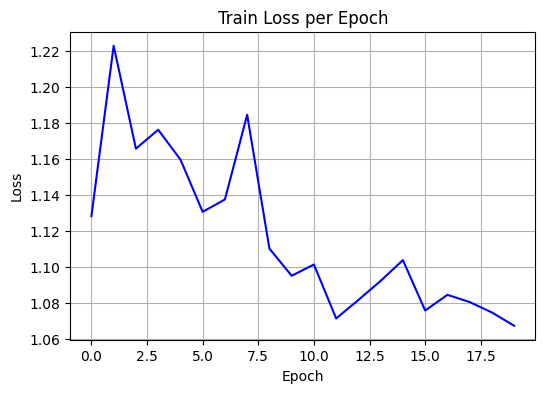

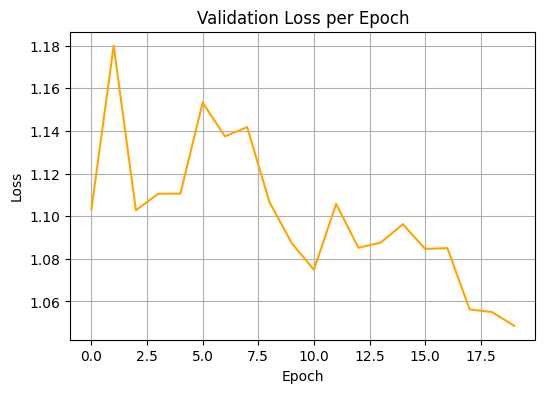

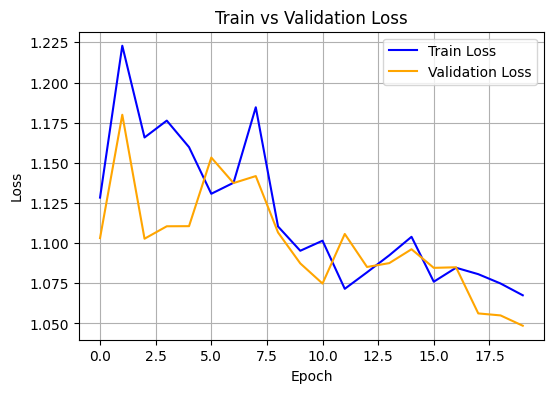

In [5]:
model_keras = result['model']

model_keras.plot_loss()

In [6]:
print("REKAP F1-SCORE PER KONFIGURASI:")
print(f"RNN {result['config']} → F1 Keras: {result['f1_keras']:.8f} | F1 Manual: {result['f1_manual']:.8f}")



REKAP F1-SCORE PER KONFIGURASI:
RNN [256] → F1 Keras: 0.32083333 | F1 Manual: 0.32083333
